# Random forest microCT image segmentation for starch in grapevine stems

#### J. Mason Earles et al. (accepted). In-vivo quantification of plant starch reserves at micrometer resolution using X-ray microCT imaging and machine learning.
#### Last Updated: 01/15/2017

### Load libraries

In [1]:
import os
import ijroi
import pandas as pd
import matplotlib as plt
from matplotlib.pyplot import subplots
from scipy import ndimage
from sima.ROI import ROI, ROIList
from skimage import io, transform, exposure
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import RFStarchCT
reload(RFStarchCT)
%matplotlib inline

### Image loading and preprocessing

In [2]:
# Polygonal regions of interest (ROIs) are initially drawn in ImageJ.
# Then, the ROIs are imported into Python below. 
# Four ROI sets are imported:

# 1. All RAPs in stem (~20-30 RAPs per stem segment)
fullRAP_roi_zip_path = "../../ML_python/_ROIs/RAP_full/"
fullRAP_roi_zip_dir = [name for name in os.listdir(fullRAP_roi_zip_path) if name !='.DS_Store']
fullRAP_roi = RFStarchCT.ROILoadFromDir(fullRAP_roi_zip_path,fullRAP_roi_zip_dir)

# 2. Subset of RAPs that were used for labeling as full/empty of starch
labelRAP_roi_zip_path = "../../ML_python/_ROIs/RAP_label/"
labelRAP_roi_zip_dir = [name for name in os.listdir(labelRAP_roi_zip_path) if name !='.DS_Store']
labelRAP_roi = RFStarchCT.ROILoadFromDir(labelRAP_roi_zip_path,labelRAP_roi_zip_dir)

# 3. Empty regions of RAP subset
label_roi_zip_path = "../../ML_python/_ROIs/StarchEmpty_label/"
label_roi_zip_dir = [name for name in os.listdir(label_roi_zip_path) if name !='.DS_Store']
label_roi = RFStarchCT.ROILoadFromDir(label_roi_zip_path,label_roi_zip_dir)

# Rectangular boxes for cropping each stem segment to remove unused background pixels
crop_roi_zip_path = "../../ML_python/_ROIs/crop/"
crop_roi_zip_dir = [name for name in os.listdir(crop_roi_zip_path) if name !='.DS_Store']
crop_roi = RFStarchCT.ROILoadFromDir(crop_roi_zip_path,crop_roi_zip_dir)[0]

In [3]:
# Import grid reconstructed CT TIFF images as numpy arrays
CT_path = "../../ML_python/_img32bit/img_subset_denoised/"
CT_dir = [name for name in os.listdir(CT_path) if name !='.DS_Store']
CT_tif = []
for i in range(0,len(CT_dir)):
    CT_tif.append(io.imread(CT_path + CT_dir[i]))

In [4]:
# Setup RAP ROIs for use in Python and generate labeled image
# Define empty lists for loop below
fullRAP_roi_list = []
labelRAP_roi_list = []
label_roi_list = []
fullRAP_mask_list = []
labelRAP_mask_list = []
label_mask_list = []
label_img_list = []

# Set img shp for ROI files
for i in range(0,len(CT_tif)):
    RFStarchCT.SetImgShp(fullRAP_roi[i],CT_tif[i])
    RFStarchCT.SetImgShp(labelRAP_roi[i],CT_tif[i])
    RFStarchCT.SetImgShp(label_roi[i],CT_tif[i])
    
    # Convert ImageJ ROI to list
    fullRAP_roi_list.append(RFStarchCT.ConvROItoList(fullRAP_roi[i]))
    labelRAP_roi_list.append(RFStarchCT.ConvROItoList(labelRAP_roi[i]))
    label_roi_list.append(RFStarchCT.ConvROItoList(label_roi[i]))
    
    # Generate ROI mask with dimensions from TIF image
    fullRAP_mask_list.append(RFStarchCT.GenROIMask(fullRAP_roi_list[i],CT_tif[i]))
    labelRAP_mask_list.append(RFStarchCT.GenROIMask(labelRAP_roi_list[i],CT_tif[i]))
    label_mask_list.append(RFStarchCT.GenROIMask(label_roi_list[i],CT_tif[i]))
    
    # Generate labeled image
    label_img_list.append(RFStarchCT.GenLabelImg(labelRAP_mask_list[i],label_mask_list[i]))

In [5]:
# Use RAP ROIs as masks on CT images
CT_tif = [RFStarchCT.ApplyROIMask(CT_tif[i],fullRAP_mask_list[i]) for i in range(0,len(CT_tif))]

In [6]:
# Crop CT image based on user defined rectangular ROI from ImageJ to reduce processing time.
# Convert ImageJ ROI to list and crop CT image
crop_roi_list = []
CT_tif_crop = []
crop_roi_tmp = RFStarchCT.ConvROItoList(crop_roi)
for i in range(0,len(crop_roi_tmp)):
    crop_roi_list.append((int(crop_roi_tmp[i][0][0]),int(crop_roi_tmp[i][1][0]),
    int(crop_roi_tmp[i][0][1]),int(crop_roi_tmp[i][3][1])))
    CT_tif_crop.append(CT_tif[i][crop_roi_list[i][2]:crop_roi_list[i][3],
                 crop_roi_list[i][0]:crop_roi_list[i][1]])

In [7]:
# Set zeros to NaN for convolution filtering to avoid RAP edge effects
for i in range(0,len(CT_tif_crop)):
     CT_tif_crop[i][CT_tif_crop[i] == 0.] = np.nan

In [8]:
# Perform contrast stretching such that each image's histogram is bounded at the 1.5th and 98.5th percentiles
# and equal to -1 and 1 respectively
p2 = [np.nanpercentile(CT_tif_crop[i], 1.5) for i in range(0,len(CT_tif_crop))]
p98 = [np.nanpercentile(CT_tif_crop[i], 98.5) for i in range(0,len(CT_tif_crop))]
CT_tif_crop = [exposure.rescale_intensity(CT_tif_crop[i], in_range=(p2[i], p98[i]), out_range=(-1,1)) for i in range(0,len(CT_tif_crop))]

### Generate feature layers

In [12]:
##############################################
# Generate feature layer array for each plant
# See RFStarchCT.GenFeatureLayers()
# This takes about 3 minutes on a quad-core machine
#
# For each plant CT image, nine feature layers are generated
# FL[0] = original CT image
# FL[1:3] = 2D Gaussian blur with stdev of 1, 9 and 15
# FL[4:7] = Sum, min, max, and mean of variance filters with 
#           window kernel dimensions of wlen_tup
# FL[8:10] = Gaussian blur on variance filters in FL[4:7]
##############################################

reload(RFStarchCT)
FL_list = RFStarchCT.GenFeatureLayers(CT_tif_crop, wlen_tup=(5,7,15,21,29))

RFStarchCT.py:136: RuntimeWarning: All-NaN axis encountered
  VRF_min = [np.nanmin(b[i],2) for i in range(0,len(b))]
RFStarchCT.py:137: RuntimeWarning: All-NaN slice encountered
  VRF_max = [np.nanmax(b[i],2) for i in range(0,len(b))]
RFStarchCT.py:138: RuntimeWarning: Mean of empty slice
  VRF_mean = [np.nanmean(b[i],2) for i in range(0,len(b))]
100%|██████████| 12/12 [00:51<00:00,  4.31s/it]


In [13]:
# Generate CT image with only the labeled RAPs
CT_tif_label = [RFStarchCT.ApplyROIMask(CT_tif[i],labelRAP_mask_list[i]) for i in range(0,len(CT_tif))]

# Set zeros to NaN
for i in range(0,len(CT_tif_label)):
     CT_tif_label[i][CT_tif_label[i] == 0] = np.nan

In [14]:
# Convert FL to original image dimensions of 2560x2560
nFL = 11
FL = np.zeros((len(CT_tif),CT_tif[0].shape[0],CT_tif[0].shape[1],nFL))
for i in range(0,len(crop_roi_tmp)):
    crop_roi_list.append((int(crop_roi_tmp[i][0][0]),int(crop_roi_tmp[i][1][0]),
    int(crop_roi_tmp[i][0][1]),int(crop_roi_tmp[i][3][1])))
    FL[i,int(crop_roi_list[i][2]):int(crop_roi_list[i][3]),
                 int(crop_roi_list[i][0]):int(crop_roi_list[i][1]),:] = FL_list[i]
    
# Set background NaN values to zero
FL[np.isnan(FL)] = 0

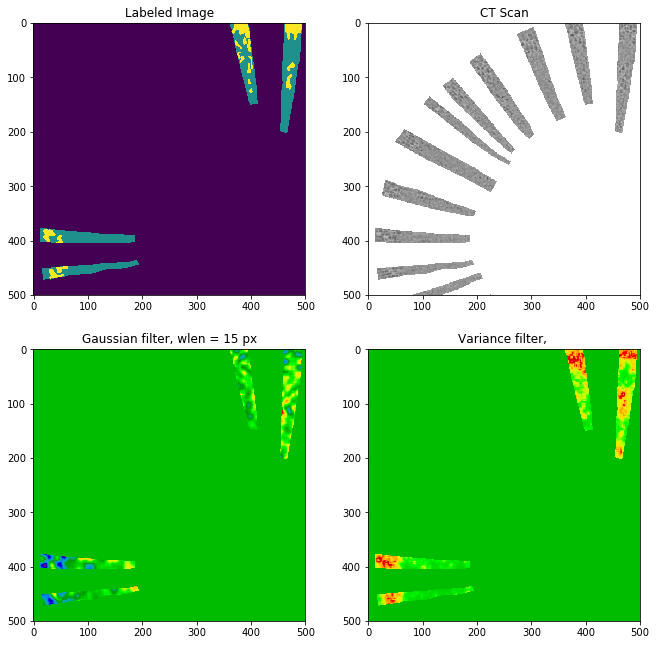

In [22]:
# Visualize data
# Initialize the subplot panels side by side
i = 0
x1 = y1 = 850
x2 = y2 = 1350
# y1 = 950
# y2 = 1750
fig, ax = plt.pyplot.subplots(nrows=2, ncols=2, figsize=(11,11))

# Show an image in each subplot
ax[0,0].imshow(label_img_list[i][x1:x2,y1:y2])
ax[0,0].set_title('Labeled Image')
ax[0,1].imshow(CT_tif[i][x1:x2,y1:y2], cmap='gray', vmin=-6, vmax = 6)
ax[0,1].set_title('CT Scan')
ax[1,0].imshow(RFStarchCT.ApplyROIMask(FL[i,:,:,3],labelRAP_mask_list[i])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[1,0].set_title('Gaussian filter, wlen = 15 px')
ax[1,1].imshow(RFStarchCT.ApplyROIMask(FL[i,:,:,7],labelRAP_mask_list[i])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[1,1].set_title('Variance filter, ')

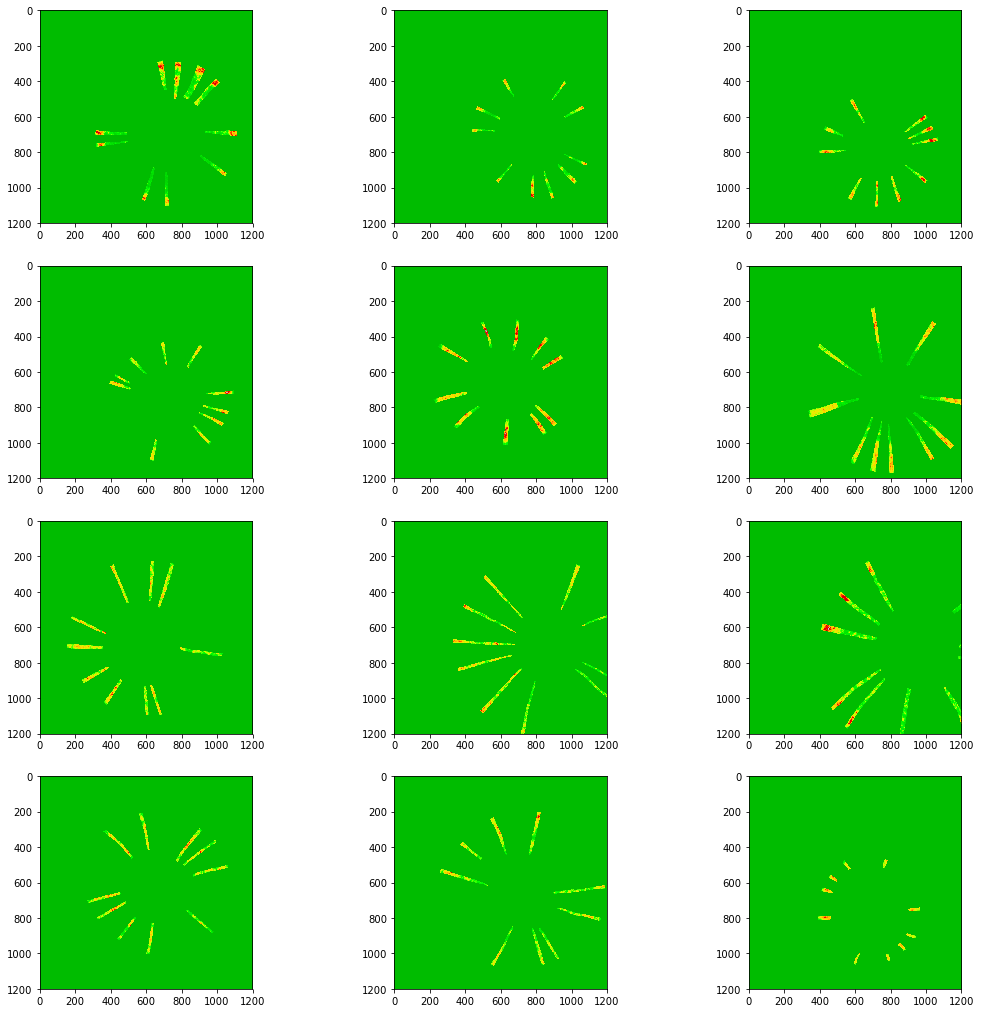

In [26]:
# Visualize data
n = 7 # set feature layer of interest; see RFStarchCT.GenFeatureLayers()
x1 = y1 = 550 # Set region of image for plotting
x2 = y2 = 1750 # Set region of image for plotting

# Initialize the subplot panels in 3 x 4 grid
fig, ax = plt.pyplot.subplots(nrows=4, ncols=3, figsize=(18,18))

# Show an image in each subplot
ax[0,0].imshow(RFStarchCT.ApplyROIMask(FL[0,:,:,n],labelRAP_mask_list[0])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[0,1].imshow(RFStarchCT.ApplyROIMask(FL[1,:,:,n],labelRAP_mask_list[1])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[0,2].imshow(RFStarchCT.ApplyROIMask(FL[2,:,:,n],labelRAP_mask_list[2])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[1,0].imshow(RFStarchCT.ApplyROIMask(FL[3,:,:,n],labelRAP_mask_list[3])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[1,1].imshow(RFStarchCT.ApplyROIMask(FL[4,:,:,n],labelRAP_mask_list[4])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[1,2].imshow(RFStarchCT.ApplyROIMask(FL[5,:,:,n],labelRAP_mask_list[5])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[2,0].imshow(RFStarchCT.ApplyROIMask(FL[6,:,:,n],labelRAP_mask_list[6])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[2,1].imshow(RFStarchCT.ApplyROIMask(FL[7,:,:,n],labelRAP_mask_list[7])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[2,2].imshow(RFStarchCT.ApplyROIMask(FL[8,:,:,n],labelRAP_mask_list[8])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[3,0].imshow(RFStarchCT.ApplyROIMask(FL[9,:,:,n],labelRAP_mask_list[9])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[3,1].imshow(RFStarchCT.ApplyROIMask(FL[10,:,:,n],labelRAP_mask_list[10])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)
ax[3,2].imshow(RFStarchCT.ApplyROIMask(FL[11,:,:,n],labelRAP_mask_list[11])[x1:x2,y1:y2], cmap='spectral', vmin=-0.5, vmax=0.5)

In [27]:
# Collapse label and feature layer arrays
label_fullset_a = []
for i in range(0,len(label_img_list)):
    label_fullset_a.append(label_img_list[i][labelRAP_mask_list[i]==1])

FL_fullset_a = []
for i in range(0,len(labelRAP_mask_list)):
    FL_fullset_a.append(FL[i,labelRAP_mask_list[i]==1,:])

In [28]:
# Expand dataset to include equal sample size from each plant sample

# Count the number of pixels in each plant sample
pixelct = [len(FL_fullset_a[i]) for i in range(0,len(FL_fullset_a))]

# Randomly sample the same number of pixels from each plant; equal to that of the plant with the max number of pixels
rand_index = [np.random.choice(len(FL_fullset_a[i]),np.max(pixelct)) for i in range(0,len(FL_fullset_a))]

# Generate dataset with equal representation of pixels from each plant sample
FL_fullset = [FL_fullset_a[i][rand_index[i],:] for i in range(0,len(FL_fullset_a))]
label_fullset = [label_fullset_a[i][rand_index[i]] for i in range(0,len(label_fullset_a))]

In [29]:
# Set plants to either testing or training sets
# Collapse to feature array
train_subset = (0,2,6,7,8,9)
test_subset = (1,3,4,5,10,11)
FL_train = np.concatenate([FL_fullset[i] for i in train_subset])
FL_test = np.concatenate([FL_fullset_a[i] for i in test_subset])
FL_all = np.concatenate(FL_fullset_a)
label_train = np.concatenate([label_fullset[i] for i in train_subset])
label_test = np.concatenate([label_fullset_a[i] for i in test_subset])
label_all = np.concatenate(label_fullset_a)

### Train Random Forest algorithm

In [30]:
# Define Random Forest classifier parameters and fit model
rf_model = RandomForestClassifier(n_estimators=100, verbose=True,
                                  oob_score=True, n_jobs=-1,
                                  warm_start=False)
rf_model = rf_model.fit(FL_train, label_train)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


### Examine prediction metrics on training dataset

In [31]:
# Print out of bag prediction accuracy
print('Our OOB prediction accuracy for is: {oob}%'.format(oob=rf_model.oob_score_ * 100))

Our OOB prediction accuracy for is: 96.3030836838%


In [32]:
# Print feature layer importance
# See RFLeafSeg module for corresponding feature layer types
feature_layers = range(0,len(rf_model.feature_importances_))
for fl, imp in zip(feature_layers, rf_model.feature_importances_):
    print('Feature_layer {fl} importance: {imp}'.format(fl=fl, imp=imp))

Feature_layer 0 importance: 0.0610580245284
Feature_layer 1 importance: 0.0621166859274
Feature_layer 2 importance: 0.0753671992958
Feature_layer 3 importance: 0.0833087064114
Feature_layer 4 importance: 0.100504768618
Feature_layer 5 importance: 0.0705102652929
Feature_layer 6 importance: 0.107116984003
Feature_layer 7 importance: 0.0956999698918
Feature_layer 8 importance: 0.0768160659238
Feature_layer 9 importance: 0.11536817487
Feature_layer 10 importance: 0.152133155238


### Predict single slices from test dataset

In [33]:
# Make prediction on test set
class_prediction = rf_model.predict(FL_test)
#class_prediction_prob = rf_model.predict_proba(FL_test)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


In [34]:
# Predict training and test set
class_prediction_all = rf_model.predict(FL_all)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.3s finished


### Examine model performance

In [35]:
# Generate normalized confusion matrix for transverse section
pd.crosstab(label_test, class_prediction, rownames=['Actual'], colnames=['Predicted'], normalize='index')

Predicted,1.0,2.0
Actual,,
1.0,0.749005,0.250995
2.0,0.229239,0.770761


In [36]:
######################
# Performance metrics
######################

# Generate absolute confusion matrix
confusion_matrix = pd.crosstab(label_test, class_prediction,
                               rownames=['Actual'], colnames=['Predicted'])

# Generate normalized confusion matrix
confusion_matrix_norm = pd.crosstab(label_test, class_prediction,
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')

# Total accuracy
print(np.diag(confusion_matrix).sum()/float(np.sum(np.sum(confusion_matrix))))

# Class precision
print(np.diag(confusion_matrix)/np.sum(confusion_matrix,1), "precision")

# Class recall
print(np.diag(confusion_matrix)/np.sum(confusion_matrix,0), "recall")

0.762132978504
(Actual
1.0    0.749005
2.0    0.770761
dtype: float64, 'precision')
(Predicted
1.0    0.682286
2.0    0.823702
dtype: float64, 'recall')


### Check test and training accuracy as a function of %full vs. %empty

In [37]:
# Generate list of predictions for each plant
FL_fullset_b = []
full_list_pred = []
full_list_label = []
for i in range(0,len(labelRAP_mask_list)):
    FL_fullset_b.append(FL[i,labelRAP_mask_list[i]==1,:])
ind_all = np.cumsum([FL_fullset_b[i].shape[0] for i in range(0,len(FL_fullset_b))])
RAP_index_all = np.append(0,ind_all)
for i in range(1,len(RAP_index_all)):
    full_list_pred.append(class_prediction_all[RAP_index_all[i-1]:RAP_index_all[i]])
    full_list_label.append(label_all[RAP_index_all[i-1]:RAP_index_all[i]])


In [42]:
######################
# Performance metrics
######################
out = []
for i in range(0,len(full_list_pred)):

    # Generate normalized confusion matrix
    confusion_matrix = pd.crosstab(full_list_label[i], full_list_pred[i],
                                   rownames=['Actual'], colnames=['Predicted'], normalize='index')

    # Total accuracy
    accuracy = np.diag(confusion_matrix).sum()/float(np.sum(np.sum(confusion_matrix)))

    # Class precision
    precision = np.diag(confusion_matrix)/np.sum(confusion_matrix,1)

    # Class recall
    recall = np.diag(confusion_matrix)/np.sum(confusion_matrix,0)

    out.append((accuracy,precision,recall))

out

[(0.97306095336819709, Actual
  1.0    0.956865
  2.0    0.989257
  dtype: float64, Predicted
  1.0    0.988897
  2.0    0.958218
  dtype: float64), (0.83815026676099647, Actual
  1.0    0.881104
  2.0    0.795197
  dtype: float64, Predicted
  1.0    0.811399
  2.0    0.869930
  dtype: float64), (0.99166853386346765, Actual
  1.0    0.988582
  2.0    0.994755
  dtype: float64, Predicted
  1.0    0.994723
  2.0    0.988652
  dtype: float64), (0.69545046068895611, Actual
  1.0    0.627790
  2.0    0.763111
  dtype: float64, Predicted
  1.0    0.726038
  2.0    0.672154
  dtype: float64), (0.77487280467318176, Actual
  1.0    0.727447
  2.0    0.822299
  dtype: float64, Predicted
  1.0    0.803677
  2.0    0.751059
  dtype: float64), (0.81738304944427531, Actual
  1.0    0.920445
  2.0    0.714321
  dtype: float64, Predicted
  1.0    0.763143
  2.0    0.899789
  dtype: float64), (0.95926055879786221, Actual
  1.0    0.963093
  2.0    0.955428
  dtype: float64, Predicted
  1.0    0.955767


In [43]:
# Calculate the percentage of RAP full for each stem segment
RAP_full = []
for i in range(0,len(full_list_label)):
    full = float(np.sum(full_list_label[i]==1))
    empty = float(np.sum(full_list_label[i]==2))
    RAP_full.append(full/(full+empty))

In [44]:
Performance_Metrics = np.zeros((12,6))
for i in range(0,len(out)):
    Performance_Metrics[i,0] = out[i][0]
    Performance_Metrics[i,1] = np.array(out[i][1])[0]
    Performance_Metrics[i,2] = np.array(out[i][1])[1]
    Performance_Metrics[i,3] = np.array(out[i][2])[0]
    Performance_Metrics[i,4] = np.array(out[i][2])[1]
    Performance_Metrics[i,5] = RAP_full[i]

In [ ]:
np.savetxt("Performance_Metrics.txt", Performance_Metrics, fmt='%1.3f')

### Visualize RAP training and testing predictions

In [45]:
# Generate images for prediction
ind_train = np.cumsum([label_fullset_a[i].shape[0] for i in train_subset])
ind_test = np.cumsum([label_fullset_a[i].shape[0] for i in test_subset])
RAP_index_train = np.append(0,ind_train)
RAP_index_test = np.append(0,ind_test)
labelRAP_mask_list_train = [labelRAP_mask_list[i] for i in train_subset]
labelRAP_mask_list_test = [labelRAP_mask_list[i] for i in test_subset]
class_prediction_img = np.zeros(np.append(len(test_subset),labelRAP_mask_list[0].shape))
for i in range(1,len(test_subset)+1):
    class_prediction_img[i-1][labelRAP_mask_list_test[i-1]==1] = class_prediction[RAP_index_test[i-1]:RAP_index_test[i]]

In [46]:
# Generate images for prediction of all samples
ind_all = np.cumsum([label_fullset_a[i].shape[0] for i in range(0,len(label_fullset_a))])
RAP_index_all = np.append(0,ind_all)
class_prediction_img_all = np.zeros(np.append(len(RAP_index_all)-1,labelRAP_mask_list[0].shape))
for i in range(1,len(RAP_index_all)):
    class_prediction_img_all[i-1,labelRAP_mask_list[i-1]==1] = class_prediction_all[RAP_index_all[i-1]:RAP_index_all[i]]

In [47]:
# Calculate the proportion of RAP that is empty
# 0 = background, 1 = full, 2 = empty
RAP_full = []
RAP_full_tot = []
for i in range(0,class_prediction_img_all.shape[0]):
    full = float(np.sum(class_prediction_img_all[i,:,:]==1))
    empty = float(np.sum(class_prediction_img_all[i,:,:]==2))
    RAP_full.append(full/(full+empty))
    RAP_full_tot.append(full)

In [48]:
# For plotting purposes
print(train_subset)
print(test_subset)

(0, 2, 6, 7, 8, 9)
(1, 3, 4, 5, 10, 11)


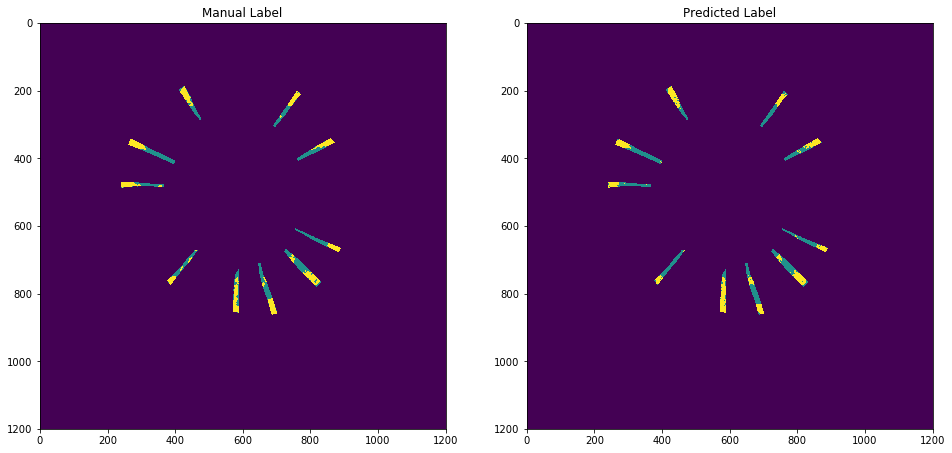

In [51]:
# Visually compare manually labeled data versus predicted
# plant sample number
i = 1

# Cropping dimensions
x1 = 750
x2 = 1950

y1 = 750
y2 = 1950

# Plot manually labeled versus predicted
fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(16,16))
ax[0].imshow(label_img_list[i][x1:x2,y1:y2])
ax[0].set_title('Manual Label')
ax[1].imshow(class_prediction_img_all[i,x1:x2,y1:y2])
ax[1].set_title('Predicted Label')

### Generate predictions for all RAPs

In [53]:
# Collapse label and feature layer arrays
FL_fullset_b = []
for i in range(0,len(labelRAP_mask_list)):
    FL_fullset_b.append(FL[i,fullRAP_mask_list[i]==1,:])
FL_full = np.concatenate(FL_fullset_b)

In [54]:
# Use trained RF model to make predictions for all RAPs across all stem segments
class_prediction_full = rf_model.predict(FL_full)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   20.4s finished


In [55]:
# Generate images for prediction of all samples
ind_all = np.cumsum([FL_fullset_b[i].shape[0] for i in range(0,len(FL_fullset_b))])
RAP_index_all = np.append(0,ind_all)
class_prediction_img_full = np.zeros(np.append(len(RAP_index_all)-1,fullRAP_mask_list[0].shape))
for i in range(1,len(RAP_index_all)):
    class_prediction_img_full[i-1,fullRAP_mask_list[i-1]==1] = class_prediction_full[RAP_index_all[i-1]:RAP_index_all[i]]

In [56]:
# For plotting purposes
print(train_subset)
print(test_subset)

(0, 2, 6, 7, 8, 9)
(1, 3, 4, 5, 10, 11)


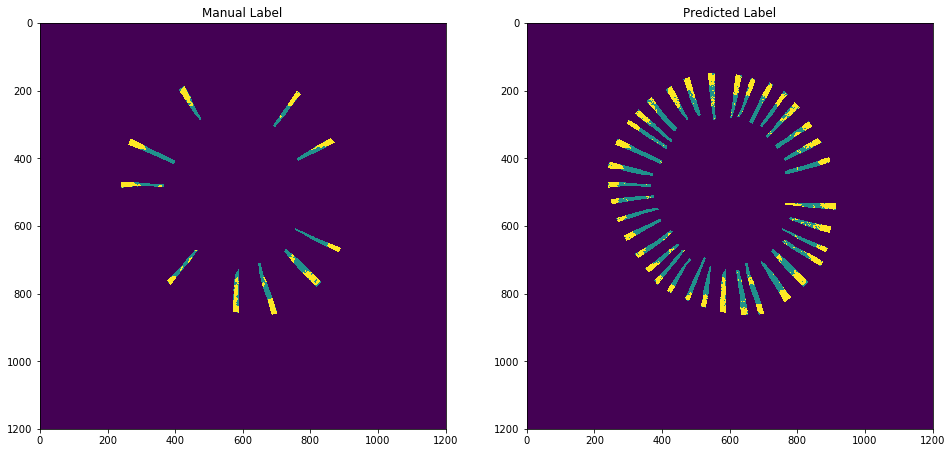

In [57]:
# Visually compare manually labeled data versus predicted
# plant sample number
i = 1


# Cropping dimensions
x1 = 750
x2 = 1950
y1 = 750
y2 = 1950

# Plot manually labeled versus predicted
fig, ax = plt.pyplot.subplots(nrows=1, ncols=2, figsize=(16,16))
ax[0].imshow(label_img_list[i][x1:x2,y1:y2])
ax[0].set_title('Manual Label')
ax[1].imshow(class_prediction_img_full[i,x1:x2,y1:y2])
ax[1].set_title('Predicted Label')

In [58]:
# Calculate the proportion of RAP that is empty
# 0 = background, 1 = full, 2 = empty
RAP_full = []
RAP_full_tot = []
for i in range(0,class_prediction_img_full.shape[0]):
    full = float(np.sum(class_prediction_img_full[i,:,:]==1))
    empty = float(np.sum(class_prediction_img_full[i,:,:]==2))
    RAP_full.append(full/(full+empty))
    RAP_full_tot.append(full)

In [59]:
# Calculate fraction RAP full
print(RAP_full)
print(labelRAP_roi_zip_dir)

[0.7271818680078667, 0.6153245231430245, 0.38997755719901794, 0.35303886719888117, 0.25080084286427695, 0.4477326692534893, 0.37691037172649844, 0.6917234574699984, 0.7277725658223299, 0.2771424361604461, 0.6497234968819862, 0.11838911218114528]
['BER_02.zip', 'BER_05.zip', 'BER_14.zip', 'BER_28.zip', 'RAM_03.zip', 'RAM_13.zip', 'RIP_08.zip', 'RIP_09.zip', 'RIP_14.zip', 'RIP_21.zip', 'RIP_25.zip', 'RIP_26.zip']
